<img height="45px" src="https://colab.research.google.com/img/colab_favicon.ico" align="left" hspace="10px" vspace="0px">

<h1>2019 Deep Learning _ HW3</h1>

MLP vs CNN vs ResNet vs ResNet with Regularizer

- Myeong-Ha Hwang

In [0]:
import numpy as np

import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms

from torchsummary import summary
from tqdm import tqdm
import torch.nn.functional as F

In [0]:
# Global Variable For training
# You just use the following hyper-parameters
BATCH_SIZE = 100
NUM_EPOCH = 50
LEARNING_RATE = 0.01
CRITERION = nn.CrossEntropyLoss()

In [21]:
# CIFAR10 Dataset
train_dataset = dsets.CIFAR10(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = dsets.CIFAR10(root='./data', train=False, transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Files already downloaded and verified


In [0]:
def fit(model,train_loader):
    model.train()
    device = next(model.parameters()).device.index
    optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9)
    losses = []
    for i, data in enumerate(train_loader):
        image = data[0].type(torch.FloatTensor).cuda(device)
        label = data[1].type(torch.LongTensor).cuda(device)
        pred_label = model(image)
        loss = CRITERION(pred_label, label)
        losses.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    avg_loss = sum(losses)/len(losses)
    return avg_loss

In [0]:
def eval(model, test_loader):
    model.eval()
    device = next(model.parameters()).device.index
    pred_labels = []
    real_labels = []

    for i, data in enumerate(test_loader):
        image = data[0].type(torch.FloatTensor).cuda(device)
        label = data[1].type(torch.LongTensor).cuda(device)
        real_labels += list(label.cpu().detach().numpy())
        
        pred_label = model(image)
        pred_label = list(pred_label.cpu().detach().numpy())
        pred_labels += pred_label
        
    real_labels = np.array(real_labels)
    pred_labels = np.array(pred_labels)
    pred_labels = pred_labels.argmax(axis=1)
    acc = sum(real_labels==pred_labels)/len(real_labels)*100
    
    return acc

# Task1: Compare between simple MLP and simple CNN

### MLP

In [0]:
class SimpleMLP(nn.Module):
    def __init__(self):
        super(SimpleMLP, self).__init__()
        self.fc1_1 = nn.Linear(3*32*32, 8*28*28) 
        self.act1_1 = nn.ReLU()
        self.fc1_2 = nn.Linear(8*28*28, 8*24*24)
        self.act1_2 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2)
        
        self.fc2_1 = nn.Linear(8*12*12, 16*8*8)
        self.act2_1 = nn.ReLU()
        self.fc2_2 = nn.Linear(16*8*8, 16*4*4)
        self.act2_2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2)

        self.out = nn.Linear(16*2*2, 10)
        
    def forward(self, x):
        x = x.view(-1, 3*32*32)
        
        x = self.act1_1(self.fc1_1(x))
        x = self.act1_2(self.fc1_2(x))
        x = x.view(-1, 8, 24, 24)
        x = self.pool1(x)
        x = x.view(-1, 8*12*12)
        
        x = self.act2_1(self.fc2_1(x))
        x = self.act2_2(self.fc2_2(x))
        x = x.view(-1, 16, 4, 4)
        x = self.pool2(x)
        x = x.view(-1, 16*2*2)

        out = self.out(x)
        return out

In [0]:
mlp_model = SimpleMLP().cuda()
train_loss1 = []
test_accuracy1 = []
for epoch in tqdm(range(NUM_EPOCH)):
    train_loss1.append(fit(mlp_model, train_loader))
    test_accuracy1.append(eval(mlp_model, test_loader))
summary(mlp_model, input_size = (3,32,32))


170500096it [01:50, 1919127.30it/s]                               
100%|██████████| 50/50 [08:04<00:00,  9.76s/it]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 6272]      19,273,856
              ReLU-2                 [-1, 6272]               0
            Linear-3                 [-1, 4608]      28,905,984
              ReLU-4                 [-1, 4608]               0
         MaxPool2d-5            [-1, 8, 12, 12]               0
            Linear-6                 [-1, 1024]       1,180,672
              ReLU-7                 [-1, 1024]               0
            Linear-8                  [-1, 256]         262,400
              ReLU-9                  [-1, 256]               0
        MaxPool2d-10             [-1, 16, 2, 2]               0
           Linear-11                   [-1, 10]             650
Total params: 49,623,562
Trainable params: 49,623,562
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Fo

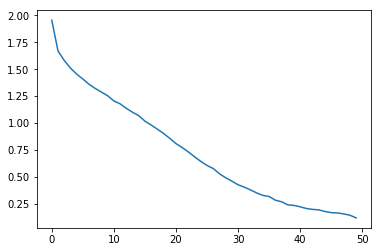

### CNN

In [0]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.layer1 = nn.Sequential(nn.Conv2d(3, 8, 5),
                                    nn.ReLU(True),
                                    nn.Conv2d(8, 8, 5),
                                    nn.ReLU(True),
                                    nn.MaxPool2d(2,2))
        
        self.layer2 = nn.Sequential(nn.Conv2d(8, 16, 5),
                                    nn.ReLU(True),
                                    nn.Conv2d(16, 16, 5),
                                    nn.ReLU(True),
                                    nn.MaxPool2d(2,2))
        
        self.fc = nn.Linear(16*2*2, 10)
       
    def forward(self, x):
        x=self.layer1(x)
        x=self.layer2(x)
        x=x.view(x.size(0), -1)
        x=self.fc(x)
        return x

In [0]:
cnn_model = SimpleCNN().cuda()
train_loss2 = []
test_accuracy2 = []
for epoch in tqdm(range(NUM_EPOCH)):
    train_loss2.append(fit(cnn_model, train_loader))
    test_accuracy2.append(eval(cnn_model, test_loader))
summary(cnn_model, input_size = (3,32,32))


100%|██████████| 50/50 [05:59<00:00,  7.17s/it]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]             608
              ReLU-2            [-1, 8, 28, 28]               0
            Conv2d-3            [-1, 8, 24, 24]           1,608
              ReLU-4            [-1, 8, 24, 24]               0
         MaxPool2d-5            [-1, 8, 12, 12]               0
            Conv2d-6             [-1, 16, 8, 8]           3,216
              ReLU-7             [-1, 16, 8, 8]               0
            Conv2d-8             [-1, 16, 4, 4]           6,416
              ReLU-9             [-1, 16, 4, 4]               0
        MaxPool2d-10             [-1, 16, 2, 2]               0
           Linear-11                   [-1, 10]             650
Total params: 12,498
Trainable params: 12,498
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/ba

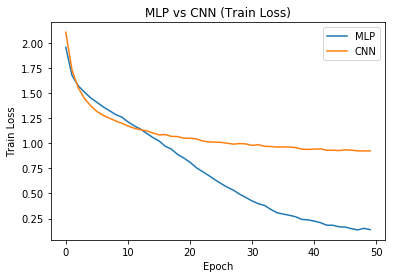

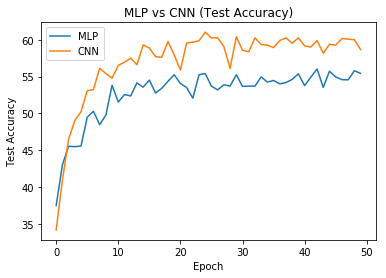

In [0]:
import matplotlib.pyplot as plt

plt.plot(train_loss1, label='MLP')
plt.plot(train_loss2, label='CNN')
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Train Loss")
plt.title('MLP vs CNN (Train Loss)')
plt.show()

plt.plot(test_accuracy1, label='MLP')
plt.plot(test_accuracy2, label='CNN')
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Test Accuracy")
plt.title('MLP vs CNN (Test Accuracy)')
plt.show()

# Task 2: Make a simple VGG and ResNet for CIFAR10

### VGG

In [0]:
class SimpleVGG(nn.Module):
    def __init__(self):
        super(SimpleVGG, self).__init__()
        self.layer1 = nn.Sequential(nn.Conv2d(3, 32, 3, 1, 1),
                                   nn.ReLU(True),
                                   nn.Conv2d(32, 32, 3, 1, 1),
                                   nn.ReLU(True),
                                   nn.MaxPool2d(2))
        
        self.layer2 = nn.Sequential(nn.Conv2d(32, 64, 3, 1, 1),
                                   nn.ReLU(True),
                                   nn.Conv2d(64, 64, 3, 1, 1),
                                   nn.ReLU(True),
                                   nn.Conv2d(64, 64, 3, 1, 1),
                                   nn.ReLU(True),
                                   nn.MaxPool2d(2))
        
        self.layer3 = nn.Sequential(nn.Conv2d(64, 128, 3, 1, 1),
                                   nn.ReLU(True),
                                   nn.Conv2d(128, 128, 3, 1, 1),
                                   nn.ReLU(True),
                                   nn.Conv2d(128, 128, 3, 1, 1),
                                   nn.ReLU(True),
                                   nn.AvgPool2d(8))
        self.fc = nn.Linear(128, 10)
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [0]:
vgg_model = SimpleVGG().cuda()
train_loss3 = []
test_accuracy3 = []
for epoch in tqdm(range(NUM_EPOCH)):
    train_loss3.append(fit(vgg_model, train_loader))
    test_accuracy3.append(eval(vgg_model, test_loader))


100%|██████████| 50/50 [09:56<00:00, 12.01s/it]


### ResNet

In [0]:
class SimpleResNet(nn.Module):
    def __init__(self):
        super(SimpleResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, 1, 1)
        self.relu1 = nn.ReLU(True)
        self.conv2 = nn.Conv2d(32, 32, 3, 1, 1)
        self.relu2 = nn.ReLU(True)
        self.max1 = nn.MaxPool2d(2)
        
        
        
        self.conv3 = nn.Conv2d(32, 64, 3, 1, 1)
        self.relu3 = nn.ReLU(True)
        self.conv4 = nn.Conv2d(64, 64, 3, 1, 1)
        self.relu4 = nn.ReLU(True)
        self.conv5 = nn.Conv2d(64, 64, 3, 1, 1)
        
        self.downsample = None
        self.stride = 1
        
        self.relu5 = nn.ReLU(True)
        self.max2 = nn.MaxPool2d(2)
        
        
        
        self.conv6 = nn.Conv2d(64, 128, 3, 1, 1)
        self.relu6 = nn.ReLU(True)
        self.conv7 = nn.Conv2d(128, 128, 3, 1, 1)
        self.relu7 = nn.ReLU(True)
        self.conv8 = nn.Conv2d(128, 128, 3, 1, 1)
        
        self.downsample = None
        self.stride = 1
            
        self.relu8 = nn.ReLU(True)
        self.avg = nn.AvgPool2d(8)
        
        
        self.fc = nn.Linear(128, 10)
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.conv2(out)
        out = self.relu2(out)
        out = self.max1(out)
        
        out = self.conv3(out)
        out = self.relu3(out)
        identity1 = out
        out = self.conv4(out)
        out = self.relu4(out)
        out = self.conv5(out)
        out += identity1
        out = self.relu5(out)
        out = self.max2(out)
        
        out = self.conv6(out)
        out = self.relu6(out)
        identity2 = out
        out = self.conv7(out)
        out = self.relu7(out)
        out = self.conv8(out)
        out += identity2
        out = self.relu8(out)
        out = self.avg(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        
        
        
        return out

In [25]:
resnet_model = SimpleResNet().cuda()
train_loss4 = []
test_accuracy4 = []
for epoch in tqdm(range(NUM_EPOCH)):
    train_loss4.append(fit(resnet_model, train_loader))
    test_accuracy4.append(eval(resnet_model, test_loader))



  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:11<09:47, 11.99s/it]

  4%|▍         | 2/50 [00:24<09:39, 12.07s/it]

  6%|▌         | 3/50 [00:36<09:30, 12.14s/it]

  8%|▊         | 4/50 [00:48<09:19, 12.16s/it]

 10%|█         | 5/50 [01:01<09:10, 12.22s/it]

 12%|█▏        | 6/50 [01:13<09:00, 12.29s/it]

 14%|█▍        | 7/50 [01:25<08:47, 12.26s/it]

 16%|█▌        | 8/50 [01:37<08:32, 12.20s/it]

 18%|█▊        | 9/50 [01:49<08:18, 12.17s/it]

 20%|██        | 10/50 [02:02<08:06, 12.16s/it]

 22%|██▏       | 11/50 [02:14<07:55, 12.19s/it]

 24%|██▍       | 12/50 [02:26<07:43, 12.21s/it]

 26%|██▌       | 13/50 [02:38<07:30, 12.18s/it]

 28%|██▊       | 14/50 [02:50<07:18, 12.17s/it]

 30%|███       | 15/50 [03:02<07:05, 12.15s/it]

 32%|███▏      | 16/50 [03:15<06:52, 12.14s/it]

 34%|███▍      | 17/50 [03:27<06:40, 12.13s/it]

 36%|███▌      | 18/50 [03:39<06:30, 12.19s/it]

 38%|███▊      | 19/50 [03:51<06:17, 12.19s/it]

 40%|████      | 20/50 [04:03<06:04,

In [0]:
import matplotlib.pyplot as plt

plt.plot(train_loss3, label='VGG')
plt.plot(train_loss4, label='ResNet')
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Train Loss")
plt.title('VGG vs ResNet (Train Loss)')
plt.show()

plt.plot(test_accuracy3, label='VGG')
plt.plot(test_accuracy4, label='ResNet')
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Test Accuracy")
plt.title('VGG vs ResNet (Test Accuracy)')
plt.show()


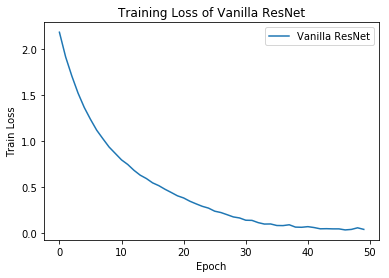

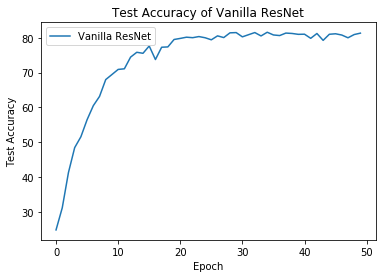

In [26]:

plt.plot(train_loss4, label = 'Vanilla ResNet')
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Train Loss")
plt.title("Training Loss of Vanilla ResNet")
plt.show()

plt.plot(test_accuracy4, label = 'Vanilla ResNet')
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Test Accuracy")
plt.title("Test Accuracy of Vanilla ResNet")
plt.show()

# Task 3 : Use various regularizers

### ResNet + Batch Normalization

In [0]:
class ResNetBN(nn.Module):
    def __init__(self):
        super(ResNetBN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, 1, 1)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU(True)
        self.conv2 = nn.Conv2d(32, 32, 3, 1, 1)
        self.bn2 = nn.BatchNorm2d(32)
        self.relu2 = nn.ReLU(True)
        self.max1 = nn.MaxPool2d(2)
        
        
        
        self.conv3 = nn.Conv2d(32, 64, 3, 1, 1)
        self.bn3 = nn.BatchNorm2d(64)
        self.relu3 = nn.ReLU(True)
        self.conv4 = nn.Conv2d(64, 64, 3, 1, 1)
        self.bn4 = nn.BatchNorm2d(64)
        self.relu4 = nn.ReLU(True)
        self.conv5 = nn.Conv2d(64, 64, 3, 1, 1)
        self.bn5 = nn.BatchNorm2d(64)
        
        self.downsample = None
        self.stride = 1
        
        self.relu5 = nn.ReLU(True)
        self.max2 = nn.MaxPool2d(2)
        
        
        
        self.conv6 = nn.Conv2d(64, 128, 3, 1, 1)
        self.bn6 = nn.BatchNorm2d(128)
        self.relu6 = nn.ReLU(True)
        self.conv7 = nn.Conv2d(128, 128, 3, 1, 1)
        self.bn7 = nn.BatchNorm2d(128)
        self.relu7 = nn.ReLU(True)
        self.conv8 = nn.Conv2d(128, 128, 3, 1, 1)
        self.bn8 = nn.BatchNorm2d(128)
        
        self.downsample = None
        self.stride = 1
            
        self.relu8 = nn.ReLU(True)
        self.avg = nn.AvgPool2d(8)
        
        
        self.fc = nn.Linear(128, 10)
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu1(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu2(out)
        out = self.max1(out)
        
        out = self.conv3(out)
        out = self.bn3(out)
        out = self.relu3(out)
        identity1 = out
        out = self.conv4(out)
        out = self.bn4(out)
        out = self.relu4(out)
        out = self.conv5(out)
        out = self.bn5(out)
        out += identity1
        out = self.relu5(out)
        out = self.max2(out)
        
        out = self.conv6(out)
        out = self.bn6(out)
        out = self.relu6(out)
        identity2 = out
        out = self.conv7(out)
        out = self.bn7(out)
        out = self.relu7(out)
        out = self.conv8(out)
        out = self.bn8(out)
        out += identity2
        out = self.relu8(out)
        out = self.avg(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        
        return out

In [30]:
resnet_bn_model = ResNetBN().cuda()
train_loss5 = []
test_accuracy5 = []
for epoch in tqdm(range(NUM_EPOCH)):
    train_loss5.append(fit(resnet_bn_model, train_loader))
    test_accuracy5.append(eval(resnet_bn_model, test_loader))



  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:13<10:56, 13.40s/it]

  4%|▍         | 2/50 [00:26<10:45, 13.46s/it]

  6%|▌         | 3/50 [00:40<10:32, 13.46s/it]

  8%|▊         | 4/50 [00:53<10:17, 13.41s/it]

 10%|█         | 5/50 [01:06<10:00, 13.35s/it]

 12%|█▏        | 6/50 [01:20<09:45, 13.30s/it]

 14%|█▍        | 7/50 [01:33<09:31, 13.29s/it]

 16%|█▌        | 8/50 [01:46<09:19, 13.32s/it]

 18%|█▊        | 9/50 [02:00<09:06, 13.33s/it]

 20%|██        | 10/50 [02:13<08:53, 13.34s/it]

 22%|██▏       | 11/50 [02:26<08:40, 13.34s/it]

 24%|██▍       | 12/50 [02:40<08:26, 13.32s/it]

 26%|██▌       | 13/50 [02:53<08:12, 13.32s/it]

 28%|██▊       | 14/50 [03:06<08:00, 13.34s/it]

 30%|███       | 15/50 [03:20<07:46, 13.32s/it]

 32%|███▏      | 16/50 [03:33<07:32, 13.31s/it]

 34%|███▍      | 17/50 [03:46<07:19, 13.31s/it]

 36%|███▌      | 18/50 [04:00<07:08, 13.38s/it]

 38%|███▊      | 19/50 [04:13<06:54, 13.39s/it]

 40%|████      | 20/50 [04:27<06:41,

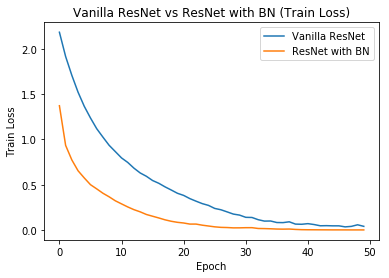

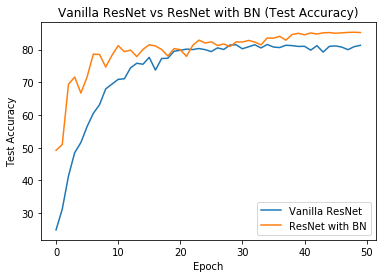

In [32]:
plt.plot(train_loss4, label='Vanilla ResNet')
plt.plot(train_loss5, label='ResNet with BN')
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Train Loss")
plt.title('Vanilla ResNet vs ResNet with BN (Train Loss)')
plt.show()

plt.plot(test_accuracy4, label='Vanilla ResNet')
plt.plot(test_accuracy5, label='ResNet with BN')
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Test Accuracy")
plt.title('Vanilla ResNet vs ResNet with BN (Test Accuracy)')
plt.show()

### ResNet + Dropout(p=0.5)

In [0]:

class ResNetDO(nn.Module):
    def __init__(self):
        super(ResNetDO, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, 1, 1)
        self.relu1 = nn.ReLU(True)
        self.conv2 = nn.Conv2d(32, 32, 3, 1, 1)
        self.relu2 = nn.ReLU(True)
        self.max1 = nn.MaxPool2d(2)
        
        
        
        self.conv3 = nn.Conv2d(32, 64, 3, 1, 1)
        self.relu3 = nn.ReLU(True)
        self.conv4 = nn.Conv2d(64, 64, 3, 1, 1)
        self.relu4 = nn.ReLU(True)
        self.conv5 = nn.Conv2d(64, 64, 3, 1, 1)
        
        self.downsample = None
        self.stride = 1
        
        self.relu5 = nn.ReLU(True)
        self.max2 = nn.MaxPool2d(2)
        
        
        
        self.conv6 = nn.Conv2d(64, 128, 3, 1, 1)
        self.relu6 = nn.ReLU(True)
        self.conv7 = nn.Conv2d(128, 128, 3, 1, 1)
        self.relu7 = nn.ReLU(True)
        self.conv8 = nn.Conv2d(128, 128, 3, 1, 1)
        
        self.downsample = None
        self.stride = 1
            
        self.relu8 = nn.ReLU(True)
        self.avg = nn.AvgPool2d(8)
        
        self.do = nn.Dropout2d(p=0.5)
        
        
        self.fc = nn.Linear(128, 10)
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.conv2(out)
        out = self.relu2(out)
        out = self.max1(out)
        
        out = self.conv3(out)
        out = self.relu3(out)
        identity1 = out
        out = self.conv4(out)
        out = self.relu4(out)
        out = self.conv5(out)
        out += identity1
        out = self.relu5(out)
        out = self.max2(out)
        
        out = self.conv6(out)
        out = self.relu6(out)
        identity2 = out
        out = self.conv7(out)
        out = self.relu7(out)
        out = self.conv8(out)
        out += identity2
        out = self.relu8(out)
        out = self.avg(out)
        out = self.do(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        
        return out

In [49]:


resnet_do_model = ResNetDO().cuda()
train_loss6 = []
test_accuracy6 = []
for epoch in tqdm(range(NUM_EPOCH)):
    train_loss6.append(fit(resnet_do_model, train_loader))
    test_accuracy6.append(eval(resnet_do_model, test_loader))



  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:11<09:26, 11.56s/it]

  4%|▍         | 2/50 [00:23<09:16, 11.59s/it]

  6%|▌         | 3/50 [00:34<09:05, 11.61s/it]

  8%|▊         | 4/50 [00:46<08:55, 11.65s/it]

 10%|█         | 5/50 [00:58<08:45, 11.67s/it]

 12%|█▏        | 6/50 [01:10<08:37, 11.77s/it]

 14%|█▍        | 7/50 [01:22<08:28, 11.84s/it]

 16%|█▌        | 8/50 [01:34<08:16, 11.83s/it]

 18%|█▊        | 9/50 [01:45<08:05, 11.83s/it]

 20%|██        | 10/50 [01:57<07:53, 11.83s/it]

 22%|██▏       | 11/50 [02:09<07:40, 11.82s/it]

 24%|██▍       | 12/50 [02:21<07:29, 11.84s/it]

 26%|██▌       | 13/50 [02:33<07:23, 11.97s/it]

 28%|██▊       | 14/50 [02:45<07:13, 12.04s/it]

 30%|███       | 15/50 [02:58<07:02, 12.06s/it]

 32%|███▏      | 16/50 [03:10<06:51, 12.10s/it]

 34%|███▍      | 17/50 [03:22<06:38, 12.07s/it]

 36%|███▌      | 18/50 [03:34<06:25, 12.04s/it]

 38%|███▊      | 19/50 [03:46<06:13, 12.05s/it]

 40%|████      | 20/50 [03:58<06:04,

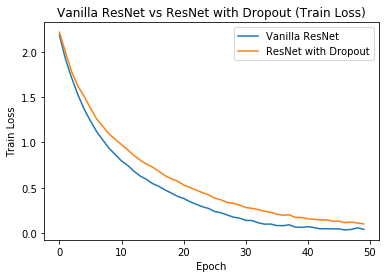

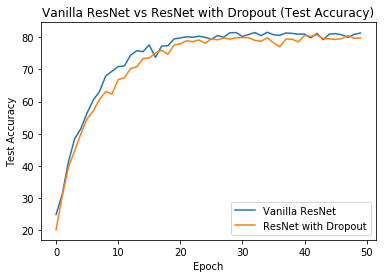

In [50]:
plt.plot(train_loss4, label='Vanilla ResNet')
plt.plot(train_loss6, label='ResNet with Dropout')
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Train Loss")
plt.title('Vanilla ResNet vs ResNet with Dropout (Train Loss)')
plt.show()

plt.plot(test_accuracy4, label='Vanilla ResNet')
plt.plot(test_accuracy6, label='ResNet with Dropout')
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Test Accuracy")
plt.title('Vanilla ResNet vs ResNet with Dropout (Test Accuracy)')
plt.show()

### VGG + Weight Decay (5e-4)

In [0]:
def fit_WD(model,train_loader):
    device = next(model.parameters()).device.index
    model.train()
    optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9, weight_decay=5e-4)
##### fill in this part using SGD optimizer with momentum of 0.9 and weight decay of 5e-4 #####
    losses = []
    for i, data in enumerate(train_loader):
        image = data[0].type(torch.FloatTensor).cuda(device)
        label = data[1].type(torch.LongTensor).cuda(device)

        pred_label = model(image)
        loss = CRITERION(pred_label, label)
        losses.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    avg_loss = sum(losses)/len(losses)
    return avg_loss

In [52]:
resnet_wd_model = SimpleResNet().cuda()
train_loss7 = []
test_accuracy7 = []
for epoch in tqdm(range(NUM_EPOCH)):
    train_loss7.append(fit_WD(resnet_wd_model, train_loader))
    test_accuracy7.append(eval(resnet_wd_model, test_loader))



  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:11<09:44, 11.92s/it]

  4%|▍         | 2/50 [00:23<09:31, 11.91s/it]

  6%|▌         | 3/50 [00:35<09:19, 11.90s/it]

  8%|▊         | 4/50 [00:47<09:06, 11.88s/it]

 10%|█         | 5/50 [00:59<09:00, 12.01s/it]

 12%|█▏        | 6/50 [01:11<08:50, 12.05s/it]

 14%|█▍        | 7/50 [01:24<08:40, 12.11s/it]

 16%|█▌        | 8/50 [01:36<08:29, 12.12s/it]

 18%|█▊        | 9/50 [01:48<08:16, 12.11s/it]

 20%|██        | 10/50 [02:00<08:03, 12.09s/it]

 22%|██▏       | 11/50 [02:12<07:54, 12.16s/it]

 24%|██▍       | 12/50 [02:25<07:44, 12.22s/it]

 26%|██▌       | 13/50 [02:37<07:32, 12.23s/it]

 28%|██▊       | 14/50 [02:49<07:20, 12.24s/it]

 30%|███       | 15/50 [03:01<07:08, 12.25s/it]

 32%|███▏      | 16/50 [03:14<06:56, 12.24s/it]

 34%|███▍      | 17/50 [03:26<06:43, 12.22s/it]

 36%|███▌      | 18/50 [03:38<06:34, 12.32s/it]

 38%|███▊      | 19/50 [03:51<06:20, 12.29s/it]

 40%|████      | 20/50 [04:03<06:07,

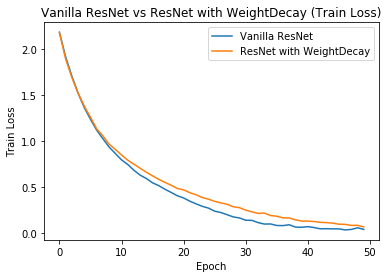

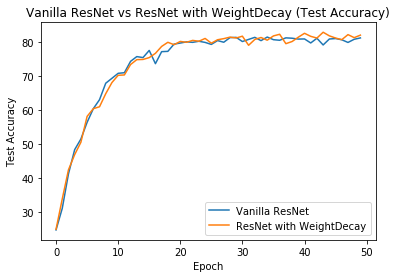

In [53]:
plt.plot(train_loss4, label='Vanilla ResNet')
plt.plot(train_loss7, label='ResNet with WeightDecay')
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Train Loss")
plt.title('Vanilla ResNet vs ResNet with WeightDecay (Train Loss)')
plt.show()

plt.plot(test_accuracy4, label='Vanilla ResNet')
plt.plot(test_accuracy7, label='ResNet with WeightDecay')
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Test Accuracy")
plt.title('Vanilla ResNet vs ResNet with WeightDecay (Test Accuracy)')
plt.show()

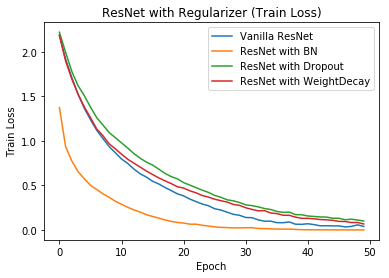

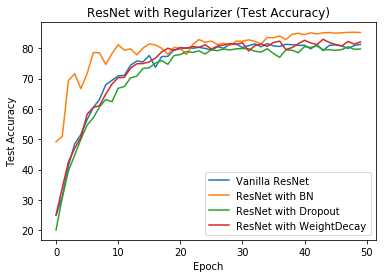

In [54]:
plt.plot(train_loss4, label='Vanilla ResNet')
plt.plot(train_loss5, label='ResNet with BN')
plt.plot(train_loss6, label='ResNet with Dropout')
plt.plot(train_loss7, label='ResNet with WeightDecay')
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Train Loss")
plt.title('ResNet with Regularizer (Train Loss)')
plt.show()

plt.plot(test_accuracy4, label='Vanilla ResNet')
plt.plot(test_accuracy5, label='ResNet with BN')
plt.plot(test_accuracy6, label='ResNet with Dropout')
plt.plot(test_accuracy7, label='ResNet with WeightDecay')
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Test Accuracy")
plt.title('ResNet with Regularizer (Test Accuracy)')
plt.show()